# Import module, packages

In [1]:
!pip install iPython_SQL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.edge.service import Service
import pandas as pd
import os
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import csv, sqlite3

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# 1. Business Understanding and Analytic Approach

•	Mục tiêu: Phân tích xu hướng giá nhà tại các khu vực nông thôn ở Việt Nam và xác định sự khác biệt so với các khu vực thành thị.   
•	Tiếp cận: Tập trung thu thập dữ liệu giá bất động sản từ các khu vực nông thôn và so sánh với dữ liệu thành thị.

# 2. Data Collection, Understanding, Preparation

### Scrap Data From BatDongSan.Com

- Em chọn cào dữ liệu từ trang "https://batdongsan.com.vn/ban-nha-dat" với filter số phòng ngủ, toilet từ 1 đến 5+ vì:
    - Các trang dữ liệu sẽ là nhà thay vì đất --> Tập trung vào phân tích giá nhà
    - Số phòng ngủ được yêu cầu cung cấp --> Hạn chế dữ liệu null cho cột số phòng ngủ, toilet.

In [3]:
def scrapping():
    # Khởi tạo trình duyệt Edge với Selenium
    service = Service('msedgedriver.exe')
    driver = webdriver.Edge(service=service)
    
    # Cào dữ liệu từ trang 1 tới trang 2000, mỗi trang trung bình 20 bất động sản
    for page in range(1,1800):
        try:
            # Initial Fields
            price_list = list()
            location_list = list()
            area_list = list()
            priceByArea_list = list()
            bedroom_list = list()
            bathroom_list = list()
            
            # Mở trang web
            url = f'https://batdongsan.com.vn/ban-nha-dat/5pn/p{page}?rs=4,3,2,1'
            driver.get(url)
            
            # Đợi một lúc cho trang tải hoàn toàn
            time.sleep(4)
            
            # Button Processed - Xử lý pop-up đánh giá trải nghiệm người dùng
            try:
                close_button = driver.find_element(By.CLASS_NAME, 'close') 
                print("Close button found!")
                # Thực hiện thao tác click
                close_button.click()
                print("Close button clicked!")
                # Kiểm tra pop-up đã tắt chưa 
                time.sleep(1)  # Wait for the closing animation
                modal = driver.find_element(By.ID, 'dialogPopup')
                if not modal.is_displayed():
                    print("Modal closed successfully!")
                else:
                    print("Modal is still visible.")
            except :
                print("Close button not found!")
            
            # Chờ trang load sau khi tắt pop-up
            time.sleep(2)
    
            # Thực hiện thao tác cuộn để trang web load hết dữ liệu
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(1) 
        
    
            # Thu thập các dữ liệu gồm: vị trí, giá, giá trên mét vuông, số phòng ngủ, số toilet
            
            # Trường vị trí
            locations = driver.find_elements(By.CLASS_NAME, 're__card-location')
            for location in locations:
                spans = location.find_elements(By.TAG_NAME, 'span')
                if location.find_elements(By.CLASS_NAME, 're__icon-location--sm') and spans:
                    location_list.append(spans[0].text)
                elif len(spans) > 1:
                    location_list.append(spans[1].text) 
                else:
                    location_list.append('Unknown')
        
            # Trường còn lại
            card_configs = driver.find_elements(By.CSS_SELECTOR, '.re__card-config.js__card-config')
            for card in card_configs:
                result = card.text.split('\n')
                # Cào giá nhà
                price_list.append(result[0])
                
                # Cào diện tích
                area_list.append(result[2])
                
                # Cào giá trên đơn vị diện tích
                priceByArea_list.append(result[4] if len(result) > 4 else 'Null')
                
                # Cào số phòng ngủ, toilet
                bedroom_list.append(result[6] if len(result) > 6 else 'Null')
                bathroom_list.append(result[8] if len(result) > 8 else 'Null')
            
            # Xử lý outlier
            if 'Vay mua nhà' in price_list:
                price_list.remove('Vay mua nhà')
        
            # Kiểm tra số lượng phần tử đã cào được
            print(f'Price: {len(price_list)}')
            print(f'Location: {len(location_list)}')
            print(f'Area: {len(area_list)}')
            print(f'Price/m2: {len(priceByArea_list)}')
            print(f'BedRoom: {len(bedroom_list)}')
            print(f'Toilet: {len(bathroom_list)}')
            
            
            # Lưu data
            data = {'Page': [page for i in range(len(price_list))],'Price': price_list, 'Location': location_list, 'Area': area_list, 'Price/m2': priceByArea_list, 
                   'BedRoom':bedroom_list, 'Toilet': bathroom_list}
            df = pd.DataFrame(data)
            if os.path.exists('HouseData.csv'):
                df.to_csv('HouseData.csv', mode='a', header=False, index=False)
            else:
                df.to_csv('HouseData.csv', mode='w', header=True, index=False)
            print(f'Page {page} is done.')
        except:
            print(f'Error with page{page}')
    # Done vòng lặp
    
    # Đóng drive trình duyệt
    driver.quit()
    
    # KẾT THÚC

### Data Cleaning

In [4]:
df = pd.read_csv('HouseData.csv')
df

,Page,Price,Location,Area,Price/m2,BedRoom,Toilet
0,1,8 tỷ,"Văn Giang, Hưng Yên",72 m²,"111,11 tr/m²",5,4
1,1,"7,4 tỷ","Văn Giang, Hưng Yên",63 m²,"117,46 tr/m²",8,4
2,1,"11,9 tỷ","Văn Giang, Hưng Yên",112 m²,"106,25 tr/m²",6,6
3,1,Giá thỏa thuận,"Đông Anh, Hà Nội",75 m²,8,7,Null
4,1,60 tỷ,"Quận 2, Hồ Chí Minh",300 m²,200 tr/m²,5,5
...,...,...,...,...,...,...,...
39899,2000,51 tỷ,"Hạ Long, Quảng Ninh",360 m²,"141,67 tr/m²",7,5
39900,2000,Giá thỏa thuận,"Quận 3, Hồ Chí Minh",124 m²,3,2,Null
39901,2000,"25,5 tỷ","Đống Đa, Hà Nội",86 m²,"296,51 tr/m²",4,7
39902,2000,"10,12 tỷ","Quận 12, Hồ Chí Minh",115 m²,88 tr/m²,2,2


In [5]:
# 1.Xử lý null

In [6]:
df['Price'] = df['Price'].apply(lambda x: x if 'Giá thỏa thuận' not in x else np.nan)
df['Price/m2'] = df['Price/m2'].apply(lambda x: x if ('Null' not in x) and ('tr/m²' in x) else np.nan)
df['BedRoom'] = df['BedRoom'].apply(lambda x: x if 'Null' not in x else np.nan)
df['Toilet'] = df['Toilet'].apply(lambda x: x if 'Null' not in x else np.nan)

In [7]:
df.isnull().sum()

Page           0
Price       4030
Location       0
Area           0
Price/m2    4111
BedRoom      247
Toilet      7210
dtype: int64

In [8]:
df.dropna(inplace=True, axis=0)
df.reset_index(inplace=True, drop=True)
df.isnull().sum()

Page        0
Price       0
Location    0
Area        0
Price/m2    0
BedRoom     0
Toilet      0
dtype: int64

In [9]:
# 2.Figure lại định dạng của từng cột

In [10]:
def convert_to_float(x):
    x = x.replace('.', '')
    x = x.replace(',', '.')
    return float(x)

def convert_unit(x):
    num = x.split(' ')[0].strip()
    num = convert_to_float(num)
    if 'tỷ' in x:
        return num * (10**9)
    elif 'triệu' in x:
        return num * (10**6)
    elif 'nghìn' in x:
        return num * (10**3)
    
# 2.1 Xử lý cột Area
df.Area = df.Area.apply(lambda x: x.split(' ')[0].strip())
df.Area = df.Area.apply(convert_to_float)

# 2.2 Xử lý cột Price/m2
df['Price/m2'] = df['Price/m2'].apply(lambda x: x.split(' ')[0].strip())
df['Price/m2'] = df['Price/m2'].apply(convert_to_float)
df['Price/m2'] = df['Price/m2'].apply(lambda x: x * 1000000) # Chuyển về đơn vị triệu

# 2.3 Xử lý cột Price
df.Price = df.Price.apply(convert_unit)

# 2.4 Xử lý cột BedRoom
df.BedRoom = df.BedRoom.apply(convert_to_float)

# 2.5 Xử lýcột Toilet
df.Toilet = df.Toilet.apply(convert_to_float)

# 2.5 Xóa cột page
df.drop(columns=['Page'], inplace = True)

#### Data Preparation

In [11]:
# Thêm thông tin cho datset

df['Province'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['AreaSegment'] = pd.cut(x=df['Area'], bins=[0, 30, 50, 100, 150, 250, 350, 500, 999999], 
                           labels=["Dưới 30m²", "30m² - 50m²", "50m² - 100m²", "100m² - 150m²", "150m² - 250m²", "250m² - 350m²", "350m² - 500m²", "Trên 500m²"])
df['PriceSegment'] = pd.cut(x=df['Price'], bins=[0, 500*(10**6), 1*(10**9), 5*(10**9), 10*(10**9), 20*(10**9), 40*(10**9), 60*(10**9), 100*(10**9), 1000*(10**9) ], 
                           labels=["Dưới 500 triệu", "500 triệu - 1 tỷ", "1 tỷ - 5 tỷ", "5 tỷ - 10 tỷ", "10 tỷ - 20 tỷ", "20 tỷ - 40 tỷ", "40 tỷ - 60 tỷ", "60 tỷ - 100 tỷ", "100 tỷ - 1000 tỷ"])

# Phân loại: Nông thôn, thành thị
country = ['Bắc Ninh', 'Bình Thuận', 'Kiên Giang', 'Thanh Hóa', 'Đắk Lắk', 'Nghệ An', 'Phú Thọ', 'Hà Nam']
city = ['Hồ Chí Minh', 'Hà Nội']

# Tạo dataframe cho từng khu vực
df_city = df.loc[df.Province.isin(city)]
df_city.reset_index(drop=True, inplace=True)

df_country = df.loc[df.Province.isin(country)]
df_country.reset_index(drop=True, inplace=True)

#### Data After Step Preparing

In [12]:
df_city = df_city[['Province', 'Location', 'Area', 'AreaSegment', 'Price/m2',	'BedRoom', 'Toilet', 'Price', 'PriceSegment']]
df_country = df_country[['Province', 'Location', 'Area', 'AreaSegment', 'Price/m2',	'BedRoom', 'Toilet', 'Price', 'PriceSegment']]

# 3. Data Analysis with SQL

In [13]:
con = sqlite3.connect("HouseData.db")
cur = con.cursor()

In [14]:
#Kích Hoạt SQL Magic
%load_ext sql

In [15]:
# Cho phép SQL Magic kết nối với CSDL
%sql sqlite:///HouseData.db

In [16]:
# Import DataFrame vào cơ sở dữ liệu
df_country.to_sql('NongThon', con, if_exists='replace', index=False)

459

In [17]:
%%sql
SELECT *
FROM NongThon
WHERE Price >= 10000000000 and BedRoom < 4;


 * sqlite:///HouseData.db
Done.


Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
Bình Thuận,"Phan Thiết, Bình Thuận",400.0,350m² - 500m²,31250000.0,3.0,4.0,12500000000.0,10 tỷ - 20 tỷ
Kiên Giang,"Rạch Giá, Kiên Giang",1635.0,Trên 500m²,13460000.0,2.0,2.0,22000000000.0,20 tỷ - 40 tỷ
Kiên Giang,"Phú Quốc, Kiên Giang",1132.0,Trên 500m²,12000000.0,3.0,2.0,13580000000.0,10 tỷ - 20 tỷ
Bình Thuận,"Phan Thiết, Bình Thuận",400.0,350m² - 500m²,37500000.0,3.0,3.0,15000000000.0,10 tỷ - 20 tỷ
Phú Thọ,"Việt Trì, Phú Thọ",119.4,100m² - 150m²,150000000.0,3.0,2.0,17910000000.0,10 tỷ - 20 tỷ
Đắk Lắk,"Buôn Ma Thuột, Đắk Lắk",72.0,50m² - 100m²,166670000.0,1.0,1.0,12000000000.0,10 tỷ - 20 tỷ
Bắc Ninh,"Từ Sơn, Bắc Ninh",180.0,150m² - 250m²,61110000.0,3.0,4.0,11000000000.0,10 tỷ - 20 tỷ
Đắk Lắk,"Buôn Ma Thuột, Đắk Lắk",160.0,150m² - 250m²,68750000.0,3.0,2.0,11000000000.0,10 tỷ - 20 tỷ
Đắk Lắk,"Buôn Ma Thuột, Đắk Lắk",115.0,100m² - 150m²,91300000.0,2.0,2.0,10500000000.0,10 tỷ - 20 tỷ
Đắk Lắk,"Buôn Ma Thuột, Đắk Lắk",115.0,100m² - 150m²,91300000.0,2.0,2.0,10500000000.0,10 tỷ - 20 tỷ


In [18]:
con.close()

# 4. Data Analysis with Python

### Phân tích giá nhà tại các tỉnh có nền kinh tế tập trung vào nông nghiệp

1.	Giá trị trung bình (mean).
2.	Trung vị (median).
3.	Độ lệch chuẩn (std).
4.	Giá trị nhỏ nhất (min).
5.	Giá trị lớn nhất (max).
6.	Phân vị thứ 25% (25% quantile).
7.	Phân vị thứ 75% (75% quantile).

In [19]:
stats = df_country.describe()
print("Thống kê mô tả tổng quát cho bất động sản:")
stats

Thống kê mô tả tổng quát cho bất động sản:


,Area,Price/m2,BedRoom,Toilet,Price
count,459.000000,4.590000e+02,459.000000,459.000000,4.590000e+02
mean,195.083203,5.613388e+07,5.041394,5.004357,9.538410e+09
std,267.348860,3.304404e+07,7.526984,7.597401,1.324629e+10
min,46.000000,5.680000e+06,1.000000,1.000000,9.000000e+08
25%,100.000000,2.998000e+07,3.000000,3.000000,4.650000e+09
50%,135.000000,5.500000e+07,4.000000,4.000000,7.050000e+09
75%,198.000000,7.071000e+07,5.000000,5.000000,1.100000e+10
max,4200.000000,2.375000e+08,108.000000,108.000000,2.200000e+11


In [20]:
# 8. Độ biến thiên giá theo khu vực
price_variance_by_location = df_country.groupby('Location')['Price'].var()
price_variance_by_location

Location
Buôn Ma Thuột, Đắk Lắk    2.075966e+19
Bắc Ninh, Bắc Ninh        8.495228e+19
Châu Thành, Kiên Giang             NaN
Cửa Lò, Nghệ An                    NaN
Hoằng Hóa, Thanh Hóa      6.312800e+19
Hà Tiên, Kiên Giang                NaN
Kim Bảng, Hà Nam          6.319524e+18
La Gi, Bình Thuận         2.318805e+21
Nghi Sơn, Thanh Hóa                NaN
Phan Thiết, Bình Thuận    5.393609e+20
Phú Quốc, Kiên Giang      1.593864e+20
Phủ Lý, Hà Nam            4.165680e+19
Rạch Giá, Kiên Giang      1.411369e+19
Sầm Sơn, Thanh Hóa        4.846214e+19
Thanh Hóa, Thanh Hóa      4.102833e+19
Thanh Liêm, Hà Nam                 NaN
Thanh Thủy, Phú Thọ       1.861600e+19
Thuận Thành, Bắc Ninh              NaN
Tuy Phong, Bình Thuận              NaN
Từ Sơn, Bắc Ninh          1.696834e+19
Vinh, Nghệ An             2.173891e+19
Việt Trì, Phú Thọ         4.251032e+19
Yên Phong, Bắc Ninh       1.177023e+21
Yên Thành, Nghệ An                 NaN
Name: Price, dtype: float64

In [21]:
# 9. Số lượng bất động sản theo từng khu vực
count_by_province = df_country['Province'].value_counts()
count_by_province

Province
Bắc Ninh      117
Bình Thuận     91
Kiên Giang     84
Thanh Hóa      41
Đắk Lắk        38
Nghệ An        37
Phú Thọ        26
Hà Nam         25
Name: count, dtype: int64

In [22]:
# 10. Hệ số biến thiên giá (coefficient of variation)
cv = df_country['Price'].std() / df_country['Price'].mean()
cv

1.3887310342827281

Hệ số biến thiên 139%: Mức độ phân tán của dữ liệu giá lớn

In [23]:
# 11. Độ lệch trung bình tuyệt đối (mean absolute deviation)
price_data = df_country['Price']
mean_price = price_data.mean()
mad = (price_data - mean_price).abs().mean()

print("Mean Absolute Deviation (MAD):", mad)

Mean Absolute Deviation (MAD): 5537975517.4885235


In [24]:
# 12. Độ phân tán của giá (range)
price_range = df_country['Price'].max() - df_country['Price'].min()
price_range

219100000000.0

In [25]:
# 13. Phân tích ngoại lệ (outliers) - sử dụng IQR (Interquartile Range)
Q1 = df_country['Price'].quantile(0.25)
Q3 = df_country['Price'].quantile(0.75)
IQR = Q3 - Q1
outliers = df_country[(df_country['Price'] < (Q1 - 1.5 * IQR)) | (df_country['Price'] > (Q3 + 1.5 * IQR))]
outliers
#outliers.sort_values(by='Price', inplace=True, ascending=True)

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
57,Kiên Giang,"Rạch Giá, Kiên Giang",1635.00,Trên 500m²,13460000.0,2.0,2.0,2.200000e+10,20 tỷ - 40 tỷ
77,Thanh Hóa,"Sầm Sơn, Thanh Hóa",228.00,150m² - 250m²,100880000.0,27.0,29.0,2.300000e+10,20 tỷ - 40 tỷ
78,Thanh Hóa,"Sầm Sơn, Thanh Hóa",228.00,150m² - 250m²,100880000.0,27.0,29.0,2.300000e+10,20 tỷ - 40 tỷ
82,Bình Thuận,"Phan Thiết, Bình Thuận",725.00,Trên 500m²,38000000.0,4.0,4.0,2.755000e+10,20 tỷ - 40 tỷ
96,Bình Thuận,"Phan Thiết, Bình Thuận",2200.00,Trên 500m²,100000000.0,58.0,58.0,2.200000e+11,100 tỷ - 1000 tỷ
135,Thanh Hóa,"Nghi Sơn, Thanh Hóa",698.00,Trên 500m²,150430000.0,81.0,81.0,1.050000e+11,100 tỷ - 1000 tỷ
194,Bắc Ninh,"Bắc Ninh, Bắc Ninh",140.00,100m² - 150m²,178570000.0,20.0,23.0,2.500000e+10,20 tỷ - 40 tỷ
235,Bắc Ninh,"Bắc Ninh, Bắc Ninh",140.00,100m² - 150m²,178570000.0,20.0,23.0,2.500000e+10,20 tỷ - 40 tỷ
258,Bắc Ninh,"Yên Phong, Bắc Ninh",4200.00,Trên 500m²,15480000.0,108.0,108.0,6.500000e+10,60 tỷ - 100 tỷ
264,Bắc Ninh,"Từ Sơn, Bắc Ninh",301.99,250m² - 350m²,100000000.0,5.0,6.0,3.020000e+10,20 tỷ - 40 tỷ


In [26]:
# 14. Phân tích tần suất xuất hiện của giá (frequency analysis)
price_frequency = df_country['PriceSegment'].value_counts()
price_frequency

PriceSegment
5 tỷ - 10 tỷ        177
1 tỷ - 5 tỷ         138
10 tỷ - 20 tỷ       117
20 tỷ - 40 tỷ        21
60 tỷ - 100 tỷ        3
100 tỷ - 1000 tỷ      2
500 triệu - 1 tỷ      1
Dưới 500 triệu        0
40 tỷ - 60 tỷ         0
Name: count, dtype: int64

In [27]:
# 15. Hệ số tương quan giữa giá và diện tích bất động sản
corr_price_area = df_country['Price'].corr(df_country['Area'])
corr_price_area

0.6126987769815814

Hệ số tương quan ~ 0.61 --> Có một mối quan hệ tương quan nhất định

In [28]:
# 16. Hệ số tương quan giữa giá và số phòng ngủ
corr_price_bedroom = df_country['Price'].corr(df_country['BedRoom'])
corr_price_bedroom

0.6058866507367371

In [29]:
# 17. Phân tích sự khác biệt giá giữa các vùng (giá trung bình giữa các vùng)
mean_price_by_location = df_country.groupby('Province')['Price'].mean()
mean_price_by_location.sort_values(ascending=False)

Province
Thanh Hóa     1.168268e+10
Bắc Ninh      1.057846e+10
Nghệ An       1.006865e+10
Bình Thuận    9.755165e+09
Hà Nam        9.088800e+09
Kiên Giang    8.498690e+09
Phú Thọ       7.798846e+09
Đắk Lắk       6.771579e+09
Name: Price, dtype: float64

Do số lượng bất động sản giữa các tỉnh chênh lệnh nhau quá nhiều --> Giá trung bình giữa các tỉnh phản ánh chưa đúng

In [30]:
# 18. Đánh giá mức độ phân tán giá
price_dispersion = df_country['Price'].std() / df_country['Price'].mean()
price_dispersion

1.3887310342827281

In [31]:
# 19. Giá trị ngoại lệ trên và dưới (dùng IQR như phần trên)
outliers_upper = df_country[df_country['Price'] > (Q3 + 1.5 * IQR)]
outliers_lower = df_country[df_country['Price'] < (Q1 - 1.5 * IQR)]
print(f'Outliers upper: {outliers_upper}')
print(f'Outliers lower: {outliers_lower}')

Outliers upper:        Province                Location     Area    AreaSegment     Price/m2  \
57   Kiên Giang    Rạch Giá, Kiên Giang  1635.00     Trên 500m²   13460000.0   
77    Thanh Hóa      Sầm Sơn, Thanh Hóa   228.00  150m² - 250m²  100880000.0   
78    Thanh Hóa      Sầm Sơn, Thanh Hóa   228.00  150m² - 250m²  100880000.0   
82   Bình Thuận  Phan Thiết, Bình Thuận   725.00     Trên 500m²   38000000.0   
96   Bình Thuận  Phan Thiết, Bình Thuận  2200.00     Trên 500m²  100000000.0   
135   Thanh Hóa     Nghi Sơn, Thanh Hóa   698.00     Trên 500m²  150430000.0   
194    Bắc Ninh      Bắc Ninh, Bắc Ninh   140.00  100m² - 150m²  178570000.0   
235    Bắc Ninh      Bắc Ninh, Bắc Ninh   140.00  100m² - 150m²  178570000.0   
258    Bắc Ninh     Yên Phong, Bắc Ninh  4200.00     Trên 500m²   15480000.0   
264    Bắc Ninh        Từ Sơn, Bắc Ninh   301.99  250m² - 350m²  100000000.0   
285   Thanh Hóa    Hoằng Hóa, Thanh Hóa   300.00  250m² - 350m²   73330000.0   
291    Bắc Ninh        T

In [32]:
# 20. Sự phân phối giá qua các phân vị
price_quantiles = df_country['Price'].quantile([0.25, 0.5, 0.75, 1.0])
price_quantiles

0.25    4.650000e+09
0.50    7.050000e+09
0.75    1.100000e+10
1.00    2.200000e+11
Name: Price, dtype: float64

# 5. Data Visualization

In [33]:
df_country.head(5)

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
0,Phú Thọ,"Thanh Thủy, Phú Thọ",400.0,350m² - 500m²,15750000.0,4.0,4.0,6.300000e+09,5 tỷ - 10 tỷ
1,Bình Thuận,"Phan Thiết, Bình Thuận",160.0,150m² - 250m²,27500000.0,3.0,3.0,4.400000e+09,1 tỷ - 5 tỷ
2,Bình Thuận,"Phan Thiết, Bình Thuận",160.0,150m² - 250m²,27500000.0,4.0,3.0,4.400000e+09,1 tỷ - 5 tỷ
3,Bắc Ninh,"Từ Sơn, Bắc Ninh",180.0,150m² - 250m²,61110000.0,4.0,5.0,1.100000e+10,10 tỷ - 20 tỷ
4,Nghệ An,"Vinh, Nghệ An",330.0,250m² - 350m²,28790000.0,5.0,5.0,9.500000e+09,5 tỷ - 10 tỷ


In [34]:
#1.	Bar Plot: So sánh giá trung bình giữa các khu vực nông thôn.

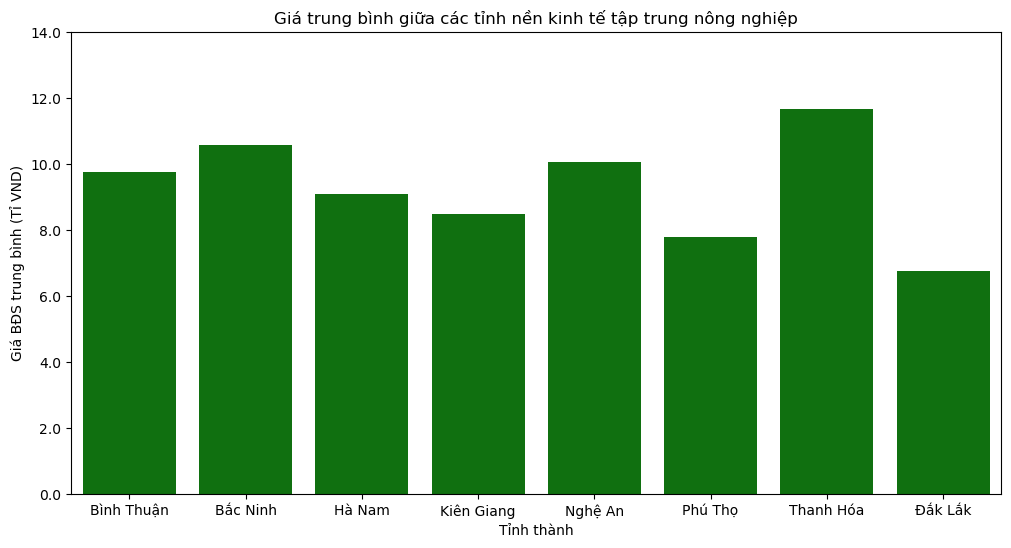

In [35]:
average_province = df_country.groupby('Province')['Price'].mean()

plt.figure(figsize=(12,6))
sns.barplot(x=average_province.index, y=average_province.values, color='Green')

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in yticks])

plt.title('Giá trung bình giữa các tỉnh nền kinh tế tập trung nông nghiệp')
plt.xlabel('Tỉnh thành')
plt.ylabel('Giá BĐS trung bình (Tỉ VND)');

In [36]:
# 2. Box Plot: Hiển thị phân phối giá ở các vùng khác nhau.

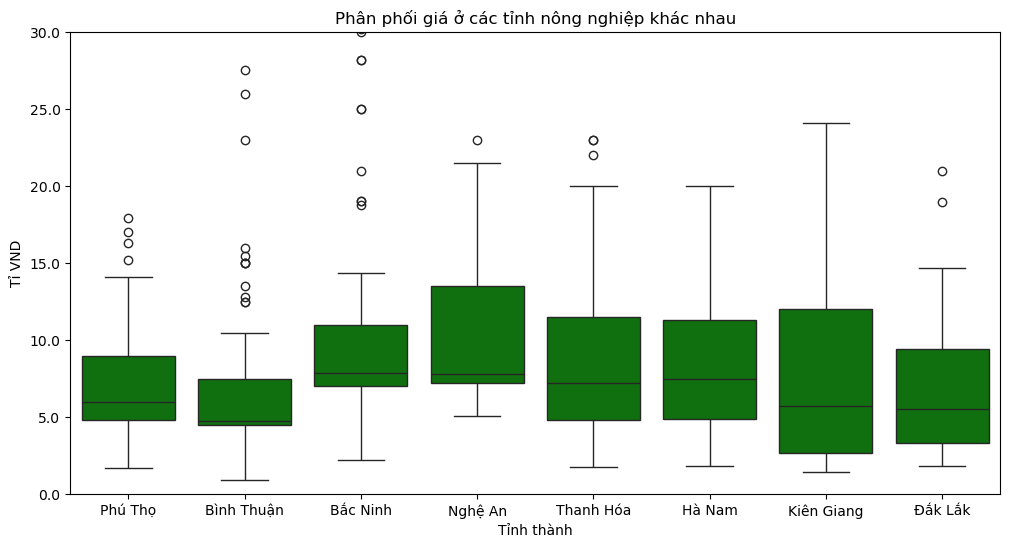

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Province', y='Price', data=df_country, color='Green')

plt.ylim(0, 30000000000)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in yticks])

plt.title('Phân phối giá ở các tỉnh nông nghiệp khác nhau')
plt.xlabel('Tỉnh thành')
plt.ylabel('Tỉ VND');

In [38]:
#3. Violin Plot: Phân tích sự phân tán giá.

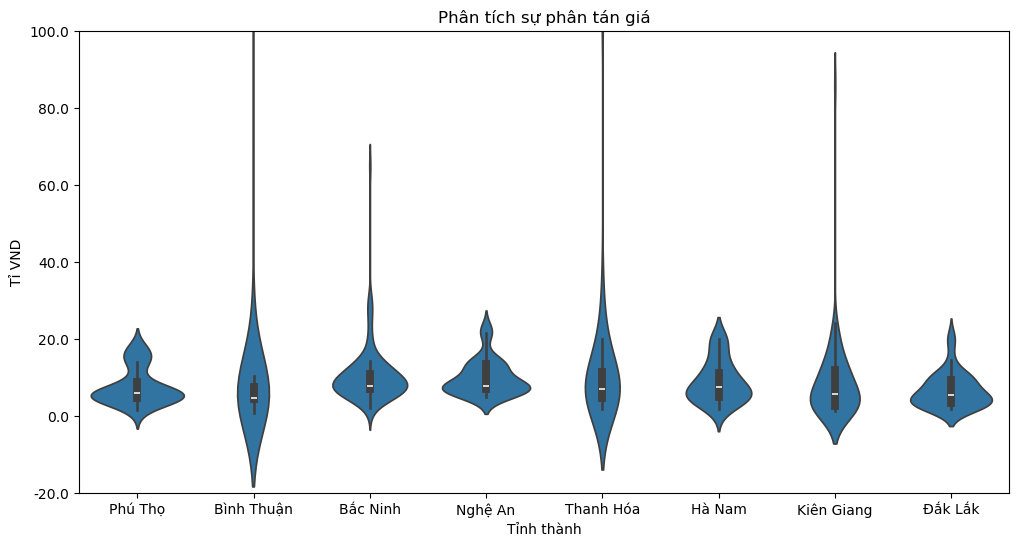

In [39]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Province', y='Price', data=df_country)

plt.ylim(-1000000, 100000000000)
yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in yticks])

plt.title('Phân tích sự phân tán giá')
plt.xlabel('Tỉnh thành')
plt.ylabel('Tỉ VND');


In [40]:
# 4.Scatter Plot: Quan hệ giữa giá và số phòng ngủ.

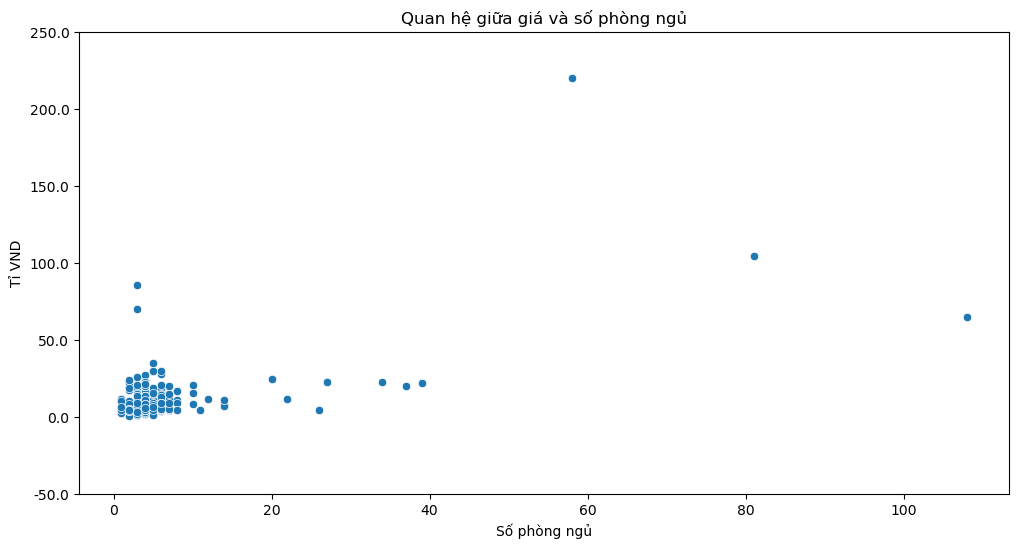

In [41]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='BedRoom', y='Price', data=df_country)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in yticks])

plt.title('Quan hệ giữa giá và số phòng ngủ')
plt.xlabel('Số phòng ngủ')
plt.ylabel('Tỉ VND');

In [42]:
# 6.Pie Chart: Phân bố số lượng bất động sản theo khu vực.

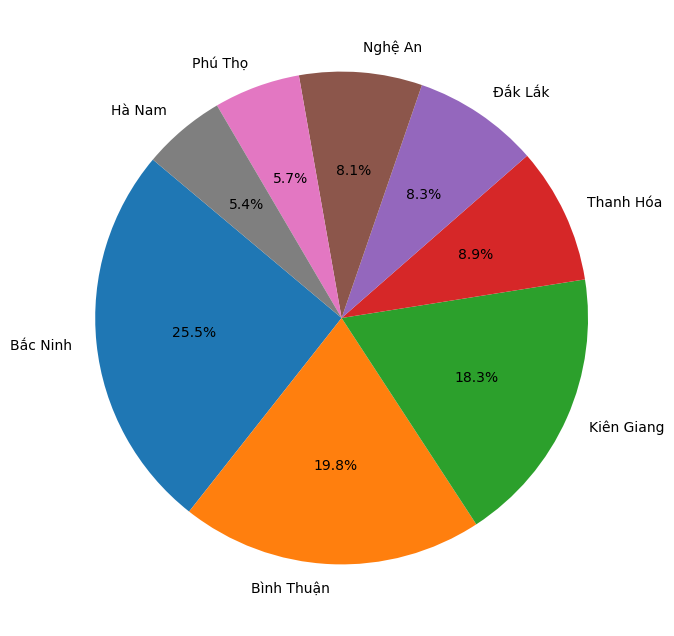

In [43]:
real_estate_counts = df_country['Province'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(real_estate_counts, labels=real_estate_counts.index, autopct='%1.1f%%', startangle=140);

In [44]:
# Histogram: Phân phối giá của bất động sản.

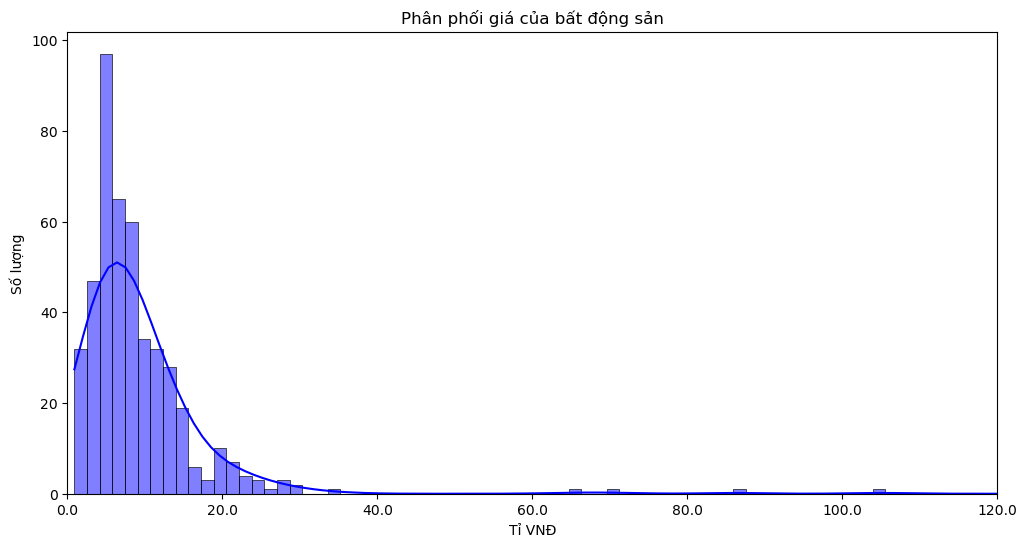

In [45]:
plt.figure(figsize=(12, 6))
sns.histplot(df_country['Price'], kde=True, color='blue')

plt.xlim(0,120000000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in xticks])

plt.title('Phân phối giá của bất động sản')
plt.xlabel('Tỉ VNĐ')
plt.ylabel('Số lượng');

In [46]:
# Histogram: Phân phối tích lũy giá nhà

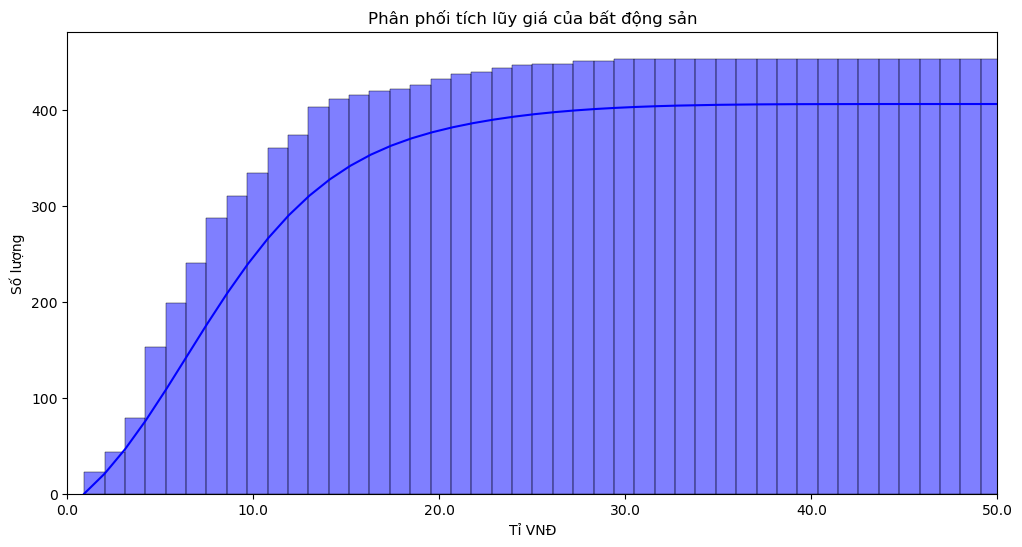

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(df_country['Price'], kde=True, color='blue', cumulative=True, bins=200)

plt.xlim(0,50000000000)
xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in xticks])

plt.title('Phân phối tích lũy giá của bất động sản')
plt.xlabel('Tỉ VNĐ')
plt.ylabel('Số lượng');

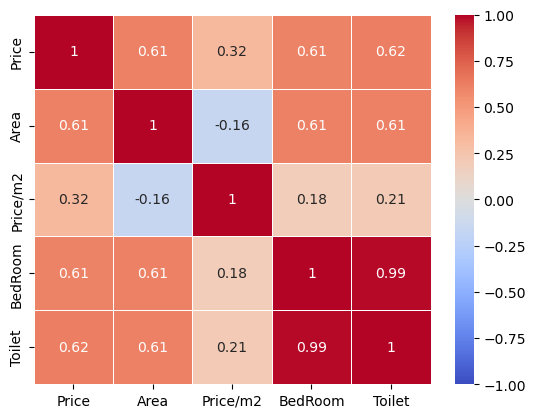

In [48]:
# Heatmap: Tương quan giữa giá và các yếu tố khác.
corr_matrix = df_country[['Price', 'Area', 'Price/m2', 'BedRoom', 'Toilet']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5);

In [49]:
# Pair Plot: Tương quan giữa các biến số khác nhau.

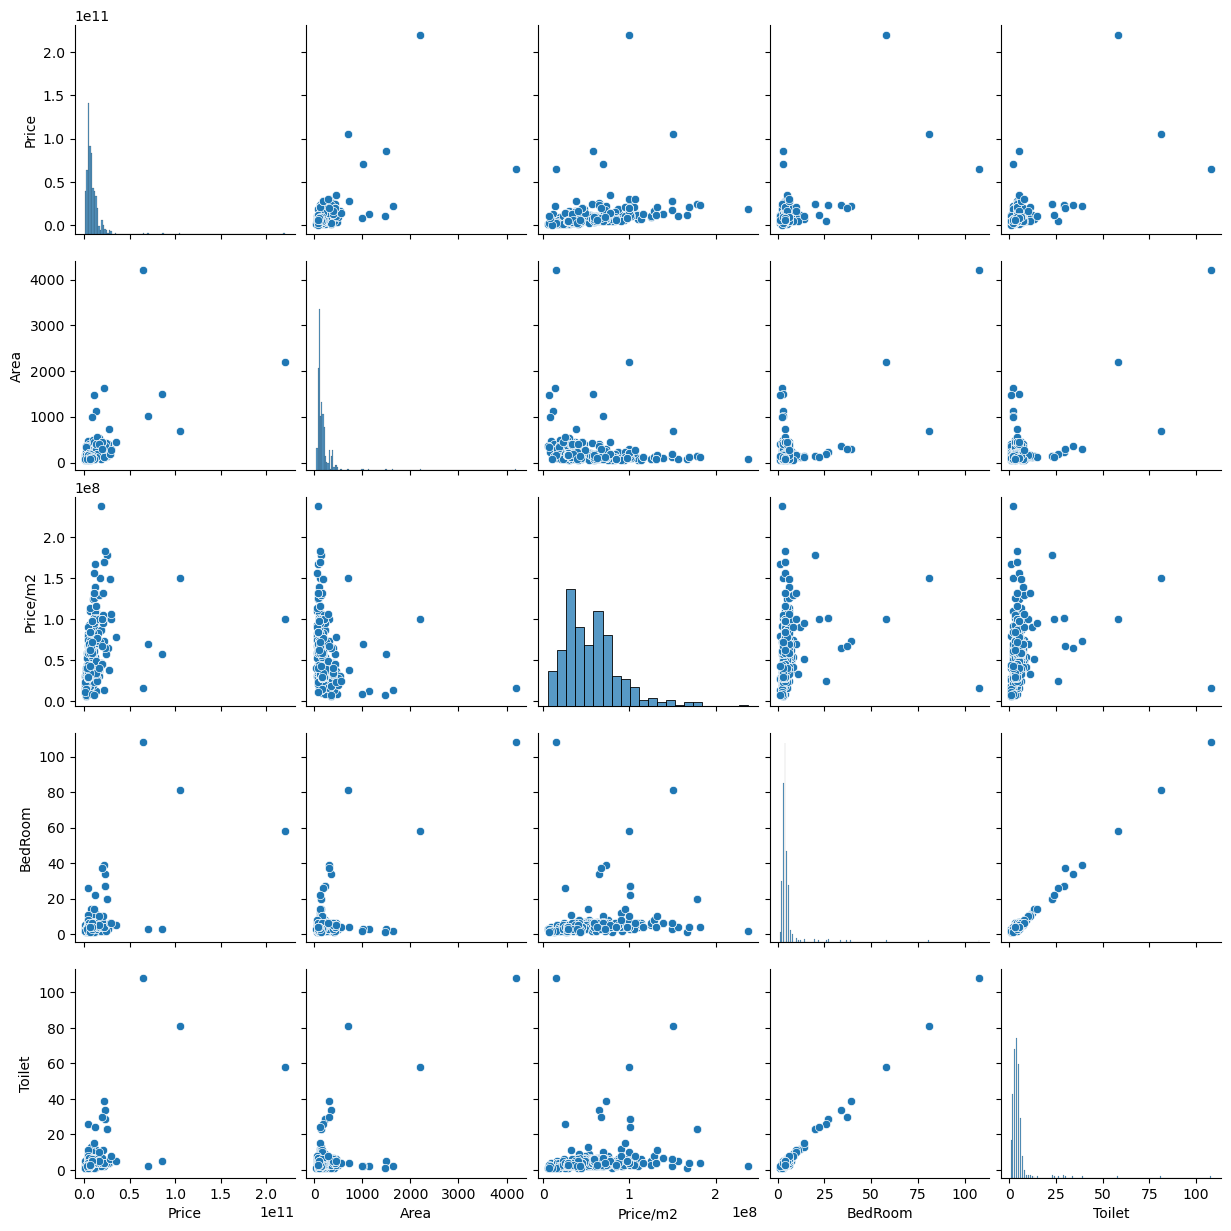

In [50]:
sns.pairplot(df_country[['Price', 'Area', 'Price/m2', 'BedRoom', 'Toilet']]);

In [51]:
# Density Plot

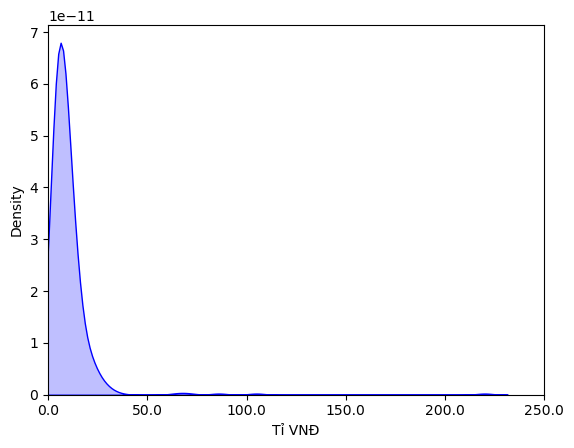

In [52]:
sns.kdeplot(df_country['Price'], color='blue', fill=True)

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in xticks])
plt.xlim(0)

plt.xlabel('Tỉ VNĐ');

In [53]:
# Area Plot: Hiển thị xu hướng giá.

''

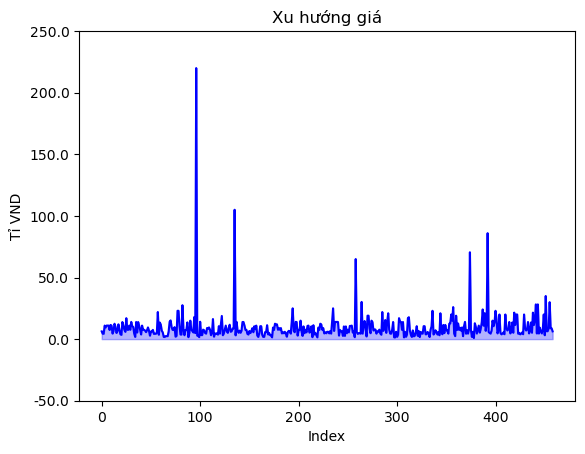

In [54]:
sns.lineplot(data=df_country['Price'], color='blue')
plt.fill_between(df_country.index, df_country['Price'], color='blue', alpha=0.3)

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in yticks])

plt.title('Xu hướng giá')
plt.xlabel('Index')
plt.ylabel('Tỉ VND')
;

In [55]:
# Biểu đồ bong bóng của giá bất động sản theo diện tích

''

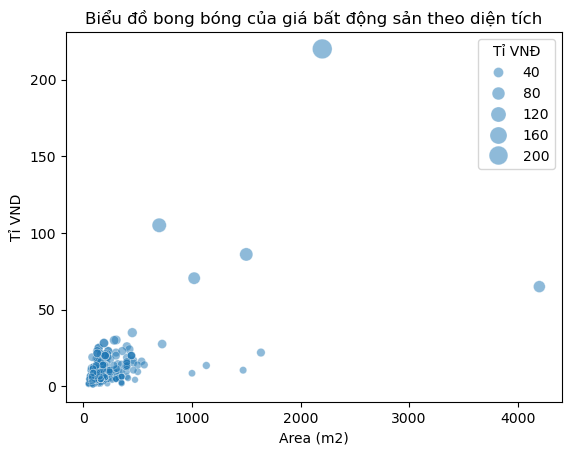

In [56]:
price_billion = df_country['Price'].apply(lambda x: x/(10**9))

sns.scatterplot(x=df_country.Area, y=price_billion, size=price_billion, sizes=(20, 200), alpha=0.5)

plt.title('Biểu đồ bong bóng của giá bất động sản theo diện tích')
plt.xlabel('Area (m2)')
plt.ylabel('Tỉ VND')

plt.legend(title='Tỉ VNĐ', fontsize='10')

;

# 6. Regression Analysis

In [57]:
# Huấn luyện mô hình
df_country['Province_encoded'] = LabelEncoder().fit_transform(df_country['Province'])
X = df_country[['Area', 'BedRoom', 'Toilet', 'Province_encoded']]
Y = df_country[['Price']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, Y_train)
price_predictions = model.predict(X_test)

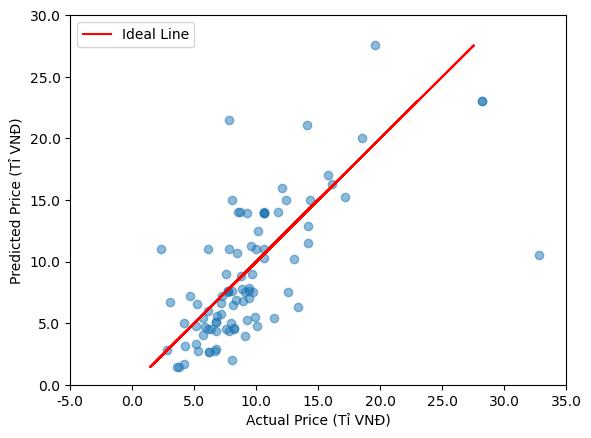

In [58]:
# Visualize khả năng dự đoán
plt.scatter(x=price_predictions, y=Y_test.values, alpha=0.5)
plt.plot(Y_test.values, Y_test.values, color='red', label='Ideal Line')

plt.ylabel('Predicted Price (Tỉ VNĐ)')
plt.xlabel('Actual Price (Tỉ VNĐ)')
plt.legend()

xticks = plt.xticks()[0]
plt.xticks(xticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in xticks])

yticks = plt.yticks()[0]
plt.yticks(yticks, labels=[f'{float(tick)/((10**9)):,.1f}' for tick in yticks]);

In [59]:
# Đánh giá hiệu suất model

In [77]:
mse = mean_squared_error(Y_test, price_predictions)
mae = mean_absolute_error(Y_test, price_predictions)
r2 = r2_score(Y_test, price_predictions)
intercept = model.intercept_  
coefficients = model.coef_   

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² score: {r2}")
print(f"Intercept (β0 - Hằng số): {intercept}")
print(f"Hệ số hồi quy (β1, β2, β3, β4): {coefficients}")

Mean Squared Error (MSE): 1.797629648800182e+19
Mean Absolute Error (MAE): 2965011054.22689
R² score: 0.3911075479981019
Intercept (β0 - Hằng số): [2.47213144e+09]
Hệ số hồi quy (β1, β2, β3, β4): [[ 2.01717027e+07 -1.30598506e+09  1.93041461e+09  6.28141814e+07]]


# 7. Data Analysis with Tool

Lưu đata đã được xử lý vào file csv để import vào PowerBI.

In [60]:
df_country

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment,Province_encoded
0,Phú Thọ,"Thanh Thủy, Phú Thọ",400.0,350m² - 500m²,15750000.0,4.0,4.0,6.300000e+09,5 tỷ - 10 tỷ,5
1,Bình Thuận,"Phan Thiết, Bình Thuận",160.0,150m² - 250m²,27500000.0,3.0,3.0,4.400000e+09,1 tỷ - 5 tỷ,0
2,Bình Thuận,"Phan Thiết, Bình Thuận",160.0,150m² - 250m²,27500000.0,4.0,3.0,4.400000e+09,1 tỷ - 5 tỷ,0
3,Bắc Ninh,"Từ Sơn, Bắc Ninh",180.0,150m² - 250m²,61110000.0,4.0,5.0,1.100000e+10,10 tỷ - 20 tỷ,1
4,Nghệ An,"Vinh, Nghệ An",330.0,250m² - 350m²,28790000.0,5.0,5.0,9.500000e+09,5 tỷ - 10 tỷ,4
...,...,...,...,...,...,...,...,...,...,...
454,Bắc Ninh,"Thuận Thành, Bắc Ninh",126.0,100m² - 150m²,71430000.0,3.0,4.0,9.000000e+09,5 tỷ - 10 tỷ,1
455,Bắc Ninh,"Bắc Ninh, Bắc Ninh",283.0,250m² - 350m²,106010000.0,6.0,8.0,3.000000e+10,20 tỷ - 40 tỷ,1
456,Bắc Ninh,"Từ Sơn, Bắc Ninh",90.0,50m² - 100m²,97780000.0,4.0,5.0,8.800000e+09,5 tỷ - 10 tỷ,1
457,Bắc Ninh,"Từ Sơn, Bắc Ninh",90.0,50m² - 100m²,97780000.0,4.0,5.0,8.800000e+09,5 tỷ - 10 tỷ,1


In [61]:
df_city

,Province,Location,Area,AreaSegment,Price/m2,BedRoom,Toilet,Price,PriceSegment
0,Hồ Chí Minh,"Quận 2, Hồ Chí Minh",300.0,250m² - 350m²,200000000.0,5.0,5.0,6.000000e+10,40 tỷ - 60 tỷ
1,Hà Nội,"Hai Bà Trưng, Hà Nội",82.0,50m² - 100m²,323170000.0,6.0,4.0,2.650000e+10,20 tỷ - 40 tỷ
2,Hà Nội,"Cầu Giấy, Hà Nội",588.0,Trên 500m²,969390000.0,48.0,50.0,5.700000e+11,100 tỷ - 1000 tỷ
3,Hà Nội,"Thường Tín, Hà Nội",87.0,50m² - 100m²,114940000.0,5.0,4.0,1.000000e+10,5 tỷ - 10 tỷ
4,Hà Nội,"Chương Mỹ, Hà Nội",36.0,30m² - 50m²,64440000.0,4.0,4.0,2.320000e+09,1 tỷ - 5 tỷ
...,...,...,...,...,...,...,...,...,...
26866,Hồ Chí Minh,"Gò Vấp, Hồ Chí Minh",70.0,50m² - 100m²,92860000.0,3.0,4.0,6.500000e+09,5 tỷ - 10 tỷ
26867,Hồ Chí Minh,"Gò Vấp, Hồ Chí Minh",60.0,50m² - 100m²,133330000.0,4.0,5.0,8.000000e+09,5 tỷ - 10 tỷ
26868,Hà Nội,"Đống Đa, Hà Nội",86.0,50m² - 100m²,296510000.0,4.0,7.0,2.550000e+10,20 tỷ - 40 tỷ
26869,Hồ Chí Minh,"Quận 12, Hồ Chí Minh",115.0,100m² - 150m²,88000000.0,2.0,2.0,1.012000e+10,10 tỷ - 20 tỷ


In [62]:
# df_city.to_csv('city.csv')
# df_country.to_csv('country.csv')